In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV

In [2]:
df = pd.read_csv('train.csv')
df = df.drop('SaleCondition', axis=1)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,250000


In [3]:
# drop the outliers
df.drop('Id', axis=1, inplace=True)
df = df.drop(df[(df['GrLivArea']>4000) & (df['SalePrice']<300000)].index)
df = df.drop(df[df['TotalBsmtSF'] > 6000].index)

In [101]:
# Check columns with missing data
df[df.columns[df.isnull().any()]].isnull().sum()

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [4]:
# Total number of bathrooms
df["TotalBath"] = df["BsmtFullBath"] + (0.5 * df["BsmtHalfBath"]) + \
df["FullBath"] + (0.5 * df["HalfBath"])
# Total SF for house (incl. basement)
df["TotalSF"] = df["GrLivArea"] + df["TotalBsmtSF"]
# Total SF for 1st + 2nd floors
df["AllFlrsSF"] = df["1stFlrSF"] + df["2ndFlrSF"]
# Total SF for porch
df["AllPorchSF"] = df["OpenPorchSF"] + df["EnclosedPorch"] + \
df["3SsnPorch"] + df["ScreenPorch"]

In [20]:
# Check categotical value of Electical column
df['Electrical'].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [5]:
# Impute missing value by SBrkr since it has the highest frequency
df.loc[df['Electrical'].isnull(), 'Electrical'] = 'SBrkr'

In [274]:
# Check missing value of column MasVnrType and MasVnrArea
df[df['MasVnrType'].isnull() == True][['MasVnrType','MasVnrArea']]

,MasVnrType,MasVnrArea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


In [32]:
# Ckeck categorical value of column MasVnrType
df['MasVnrType'].value_counts()

None       863
BrkFace    445
Stone      128
BrkCmn      15
SBrkr        1
Name: MasVnrType, dtype: int64

In [6]:
# MasVnrType MasVnrType have the same rows of missing value, None is the most frequent value for MasVnrType
# From my guessing, Impute 0.0 for missing value in column MasVnrArea
df.loc[df['MasVnrType'].isnull(), 'MasVnrType'] = 'None'
df.loc[df['MasVnrArea'].isnull(), 'MasVnrArea'] = 0.0

In [90]:
# Get column name related with Basement
bsmt_col = [i for i in df.columns if 'Bsmt' in i]

In [49]:
# Check the missing value related with basement
df[df['BsmtExposure'].isnull() == True][bsmt_col]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
17,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
39,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
90,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
102,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
156,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
182,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
259,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
342,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
362,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0
371,NaN,NaN,NaN,NaN,0,NaN,0,0,0,0,0


In [40]:
# Check values in column BsmtExposure
df['BsmtExposure'].value_counts()

No       945
Av       221
Gd       133
Mn       114
None       8
SBrkr      1
Name: BsmtExposure, dtype: int64

In [7]:
# Impute column BsmtExposure, index=948 with value 'No', since it has basement
df.loc[948, 'BsmtExposure'] = 'No'

In [8]:
# Impute 'NO_bsme' to column related besement is missing, since the area of basement is 0
for i in ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']:
    df.loc[df[i].isnull() == True, i] = 'NO_bsmt'

In [70]:
# Check missing value of columns related with garage
garage_col = [i for i in df.columns if 'Garage' in i]
df[df['GarageType'].isnull() == True][garage_col]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
48,NaN,NaN,NaN,0,0,NaN,NaN
78,NaN,NaN,NaN,0,0,NaN,NaN
88,NaN,NaN,NaN,0,0,NaN,NaN
89,NaN,NaN,NaN,0,0,NaN,NaN
99,NaN,NaN,NaN,0,0,NaN,NaN
108,NaN,NaN,NaN,0,0,NaN,NaN
125,NaN,NaN,NaN,0,0,NaN,NaN
127,NaN,NaN,NaN,0,0,NaN,NaN
140,NaN,NaN,NaN,0,0,NaN,NaN
148,NaN,NaN,NaN,0,0,NaN,NaN


In [9]:
# Impute 'NO_garage' to column related garage is missing, since the area of garage is 0
for i in ['GarageType','GarageFinish','GarageQual','GarageCond']:
    df.loc[df[i].isnull() == True, i] = 'NO_garage'

In [10]:
df.loc[df['GarageYrBlt'].isnull( )== True, 'GarageYrBlt'] = 0

In [90]:
# Check missing value of columns related with fireplace. Because there are too many missing values in column FireplaceQu
# I will show the value of Fireplaces when values in column FireplaceQu are missing
garage_col = [i for i in df.columns if 'Fire' in i]
df[df['FireplaceQu'].isnull() == True][garage_col]['Fireplaces'].value_counts()

0    591
Name: Fireplaces, dtype: int64

In [11]:
# When FireplaceQu has missing value, the value of column Fireplaces is 0. Means there is no Fireplaces in the house
# Impute FireplaceQu with 'No_fireplace'
df.loc[df['FireplaceQu'].isnull() == True, 'FireplaceQu'] = 'NO_fireplace'

In [12]:
# Impute Fence with 'No_fence'
df.loc[df['Fence'].isnull() == True, 'Fence'] = 'No_fence'

In [13]:
# I will drop column Alley, MiscFeature, PoolQC since it has over 90% missing value
df = df.drop(['Alley'], axis=1)
df = df.drop(['MiscFeature'], axis=1)
df = df.drop(['PoolQC'], axis=1)

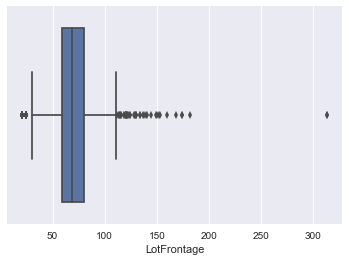

In [128]:
# boxplot of column LotFrontage
sns.boxplot(x="LotFrontage", data=df) 

In [13]:
df[df.columns[df.isnull().any()]].isnull().sum()

Series([], dtype: float64)

In [292]:
df['LotFrontage'].corr(df['LotArea'])

0.42609501877180816

In [290]:
df['LotFrontage'].corr((df['LotArea'])**(1/2))

0.6020022167939364

In [289]:
df['LotFrontage'].corr((df['LotArea'])**(1/3))

0.63198369593100656

In [293]:
df['LotFrontage'].corr((df['LotArea'])**(1/4))

0.64166411638016352

In [14]:
# Impute missing value of LotFrontage column
df.loc[df['LotFrontage'].isnull() == True, 'LotFrontage'] = df['LotArea']**(1/4)

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

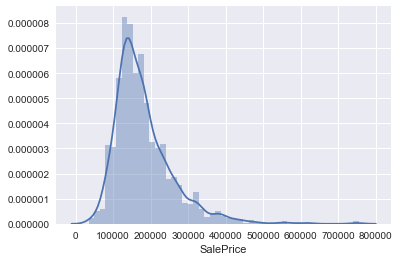

In [135]:
# Check distrubution of target column: SalePrice
# Check if it has negative value 
sns.distplot(df['SalePrice'])
#plt.hist(df['SalePrice'])
df['SalePrice'].describe()

In [15]:
# create a dictionary for ExterQual value
exterqual_dict = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}
df['ExterQual'] = df['ExterQual'].map(exterqual_dict)

In [16]:
# create a dictionary for ExterCond value
extercond_dict = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}
df['ExterCond'] = df['ExterCond'].map(extercond_dict)

In [17]:
bsmtqual_dict = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NO_bsmt':0}
df['BsmtQual'] = df['BsmtQual'].map(bsmtqual_dict)

In [18]:
bsmtcond_dict = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NO_bsmt':0}
df['BsmtCond'] = df['BsmtCond'].map(bsmtcond_dict)

In [19]:
bsmtexposure_dict = {'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'NO_bsmt':0}
df['BsmtExposure'] = df['BsmtExposure'].map(bsmtexposure_dict)

In [20]:
heatingqc_dict = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}
df['HeatingQC'] = df['HeatingQC'].map(heatingqc_dict)

In [21]:
centralair_dict = {'Y':1, 'N':0}
df['CentralAir'] = df['CentralAir'].map(centralair_dict)

In [22]:
KitchenQual_dict = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}
df['KitchenQual'] = df['KitchenQual'].map(KitchenQual_dict)

In [23]:
FireplaceQu_dict = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1,'NO_fireplace':0}
df['FireplaceQu'] = df['FireplaceQu'].map(FireplaceQu_dict)

In [24]:
GarageFinish_dict = {'Fin':3, 'RFn':2, 'Unf':1,'NO_garage':0}
df['GarageFinish'] = df['GarageFinish'].map(GarageFinish_dict)

In [25]:
GarageQual_dict = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1,'NO_garage':0}
df['GarageQual'] = df['GarageQual'].map(GarageQual_dict)

In [26]:
GarageCond_dict = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1,'NO_garage':0}
df['GarageCond'] = df['GarageCond'].map(GarageCond_dict)

In [27]:
PavedDrive_dict = {'Y':3, 'P':2, 'N':1}
df['PavedDrive'] = df['PavedDrive'].map(PavedDrive_dict)

In [28]:
Fence_dict = {'GdPrv':4, 'MnPrv':3, 'GdWo':2, 'MnWw':1,'No_fence':0}
df['Fence'] = df['Fence'].map(Fence_dict)

In [29]:
BsmtFinType1_dict = {'GLQ':6,'ALQ':5,'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1,'NO_bsmt':0}
df['BsmtFinType1'] = df['BsmtFinType1'].map(BsmtFinType1_dict)

In [30]:
BsmtFinType2_dict = {'GLQ':6,'ALQ':5,'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1,'NO_bsmt':0}
df['BsmtFinType2'] = df['BsmtFinType2'].map(BsmtFinType2_dict)

functional_dict = {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, "Min2" : 6, "Min1" : 7, "Typ" : 8}
df['Functional'] = df['Functional'].map(functional_dict)

LandSlope = {"Sev" : 1, "Mod" : 2, "Gtl" : 3}
df['LandSlope'] = df['LandSlope'].map(LandSlope)

LotShape = {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4}
df['LotShape'] = df['LotShape'].map(LotShape)

Street = {"Grvl" : 1, "Pave" : 2}
df['Street'] = df['Street'].map(Street)

In [31]:
# MSSubClass: The building class
df['MSSubClass'] = df['MSSubClass'].apply(str)

# Year and month sold are transformed into categorical features.
df['YrSold'] = df['YrSold'].astype(str)
df['MoSold'] = df['MoSold'].astype(str)

In [32]:
# Trail
df_dummy = pd.get_dummies(df)
trail_corr = df_dummy.corr()[['SalePrice']].sort_values('SalePrice', ascending=False)
trail_high_corr = trail_corr[abs(trail_corr['SalePrice']) > 0.05].drop(['SalePrice'])

In [89]:
trail_high_corr

,SalePrice
TotalSF,0.832877
OverallQual,0.795774
GrLivArea,0.734968
ExterQual,0.686756
KitchenQual,0.662236
TotalBsmtSF,0.651153
GarageCars,0.641047
1stFlrSF,0.631530
GarageArea,0.629217
BsmtQual,0.586674


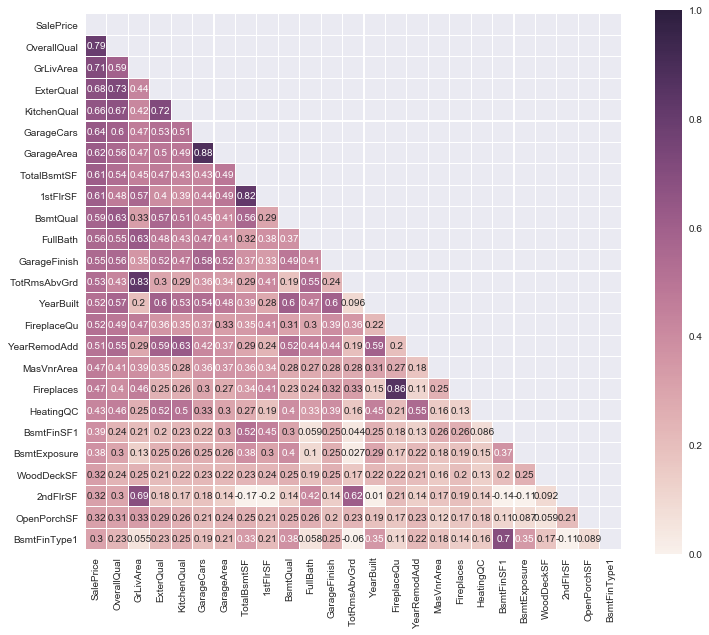

In [50]:
# Show the correlation heatmap between numeric fearures
col_name = trail_high_corr.index
data = np.corrcoef(df[col_name].values.T)

fig, ax = plt.subplots(figsize=(12,10))
mask = np.zeros_like(data)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data,mask=mask, annot=True,vmin=0,linewidth=.2, yticklabels=col_name.values, xticklabels=col_name.values, square=True)

In [33]:
df_dummy.loc[df_dummy['BsmtExposure'].isnull(), 'BsmtExposure'] = 0

# trail
X = df_dummy[trail_high_corr.index]
y = df['SalePrice'] 

In [34]:
# Scaler data
Xs = StandardScaler().fit_transform(X)

In [35]:
from sklearn.kernel_ridge import KernelRidge
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
KRR.fit(Xs, y)

KernelRidge(alpha=0.6, coef0=2.5, degree=2, gamma=None, kernel='polynomial',
      kernel_params=None)

In [36]:
cross_val_score(KRR, Xs, y, cv=5).mean()

0.93156118615937333

In [37]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [39]:
ada = AdaBoostRegressor()
ada_params = {'n_estimators': [25,50,75,100]}
ada_model = GridSearchCV(ada, param_grid=ada_params)
cross_val_score(ada, Xs, y, cv=5).mean()

0.84136556316216837

In [40]:
gb = GradientBoostingRegressor()
gb.fit(Xs, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [41]:
cross_val_score(gb, Xs, y, cv=5).mean()

0.92191988594039986

In [50]:
eln = ElasticNet()
eln_dict = {'alpha':np.logspace(-1,2,20), 'l1_ratio':np.linspace(0,1,10)}
#grid_search = GridSearchCV(eln, eln_dict, verbose=1, n_jobs=-1)
#grid_search.fit(Xs, y)

In [47]:
grid_search.best_params_

{'alpha': 1.2742749857031335, 'l1_ratio': 0.88888888888888884}

In [48]:
sale_price_model = grid_search.best_estimator_

In [49]:
cross_val_score(sale_price_model, Xs, y, cv=5).mean()

0.89394557289790522

In [102]:
# Load test data
test = pd.read_csv('/Users/fmeng90/kaylee_DSI/projects/project_3/test.csv') #(879,80)

In [103]:
test.columns = [i.replace(' ','') for i in test.columns]
test.columns = [i.replace('/','') for i in test.columns]

In [104]:
# Total number of bathrooms
test["TotalBath"] = test["BsmtFullBath"] + (0.5 * test["BsmtHalfBath"]) + \
test["FullBath"] + (0.5 * test["HalfBath"])
# Total SF for house (incl. basement)
test["TotalSF"] = test["GrLivArea"] + test["TotalBsmtSF"]
# Total SF for 1st + 2nd floors
test["AllFlrsSF"] = test["1stFlrSF"] + test["2ndFlrSF"]
# Total SF for porch
test["AllPorchSF"] = test["OpenPorchSF"] + test["EnclosedPorch"] + \
test["3SsnPorch"] + test["ScreenPorch"]

In [105]:
# Impute missing value for 'Electrical' by SBrkr since it has the highest frequency
test.loc[test['Electrical'].isnull(), 'Electrical'] = 'SBrkr'

# MasVnrType MasVnrType have the same rows of missing value, None is the most frequent value for MasVnrType
# From my guessing, Impute 0.0 for missing value in column MasVnrArea
test.loc[test['MasVnrType'].isnull(), 'MasVnrType'] = 'None'
test.loc[test['MasVnrArea'].isnull(), 'MasVnrArea'] = 0.0

# Impute 'NO_bsme' to column related besement is missing, since the area of basement is 0
for i in ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']:
    test.loc[test[i].isnull() == True, i] = 'NO_bsmt'

# Impute 'NO_garage' to column related garage is missing, since the area of garage is 0
for i in ['GarageType','GarageFinish','GarageQual','GarageCond']:
    test.loc[test[i].isnull() == True, i] = 'NO_garage'

test.loc[test['GarageYrBlt'].isnull( )== True, 'GarageYrBlt'] = 0

# When FireplaceQu has missing value, the value of column Fireplaces is 0. Means there is no Fireplaces in the house
# Impute FireplaceQu with 'No_fireplace'
test.loc[test['FireplaceQu'].isnull() == True, 'FireplaceQu'] = 'NO_fireplace'

# Impute Fence with 'No_fence'
test.loc[test['Fence'].isnull() == True, 'Fence'] = 'No_fence'

# I will drop column Alley, MiscFeature, PoolQC since it has over 90% missing value
test = test.drop(['Alley'], axis=1)
test = test.drop(['MiscFeature'], axis=1)
test = test.drop(['PoolQC'], axis=1)

# Impute missing value of LotFrontage column
test.loc[test['LotFrontage'].isnull() == True, 'LotFrontage'] = test['LotArea']**(1/4)

In [106]:
# chenge object value to int
dict1 = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}
test['ExterQual'] = test['ExterQual'].map(dict1)
test['ExterCond'] = test['ExterCond'].map(dict1)
test['HeatingQC'] = test['HeatingQC'].map(dict1)
test['KitchenQual'] = test['KitchenQual'].map(dict1)

bsmt_dict = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NO_bsmt':0}
test['BsmtQual'] = test['BsmtQual'].map(bsmt_dict)
test['BsmtCond'] = test['BsmtCond'].map(bsmt_dict)
test['BsmtExposure'] = test['BsmtExposure'].map(bsmt_dict)

Garage_dict = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1,'NO_garage':0}
test['GarageQual'] = test['GarageQual'].map(Garage_dict)
test['GarageCond'] = test['GarageCond'].map(Garage_dict)

GarageFinish_dict = {'Fin':3, 'RFn':2, 'Unf':1,'NO_garage':0}
test['GarageFinish'] = test['GarageFinish'].map(GarageFinish_dict)

FireplaceQu_dict = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1,'NO_fireplace':0}
test['FireplaceQu'] = test['FireplaceQu'].map(FireplaceQu_dict)

centralair_dict = {'Y':1, 'N':0}
test['CentralAir'] = test['CentralAir'].map(centralair_dict)

PavedDrive_dict = {'Y':3, 'P':2, 'N':1}
test['PavedDrive'] = test['PavedDrive'].map(PavedDrive_dict)

Fence_dict = {'GdPrv':4, 'MnPrv':3, 'GdWo':2, 'MnWw':1,'No_fence':0}
test['Fence'] = test['Fence'].map(Fence_dict)

BsmtFinType_dict = {'GLQ':6,'ALQ':5,'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1,'NO_bsmt':0}
test['BsmtFinType1'] = test['BsmtFinType1'].map(BsmtFinType_dict)
test['BsmtFinType2'] = test['BsmtFinType2'].map(BsmtFinType_dict)

functional_dict = {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, "Min2" : 6, "Min1" : 7, "Typ" : 8}
test['Functional'] = test['Functional'].map(functional_dict)

LandSlope = {"Sev" : 1, "Mod" : 2, "Gtl" : 3}
test['LandSlope'] = test['LandSlope'].map(LandSlope)

LotShape = {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4}
test['LotShape'] = test['LotShape'].map(LotShape)

Street = {"Grvl" : 1, "Pave" : 2}
test['Street'] = test['Street'].map(Street)

In [107]:
# MSSubClass: The building class
test['MSSubClass'] = test['MSSubClass'].apply(str)

# Year and month sold are transformed into categorical features.
test['YrSold'] = test['YrSold'].astype(str)
test['MoSold'] = test['MoSold'].astype(str)

In [108]:
test_dummy = pd.get_dummies(test)

In [109]:
test_dummy = test_dummy.rename(columns = {'SaleType_WD ':'SaleType_WD'})

In [110]:
set(trail_high_corr.index) - set(test_dummy.columns)

set()

In [111]:
test_dummy[test_dummy.columns[test_dummy.isnull().any()]].isnull().sum()

BsmtExposure    773
dtype: int64

In [112]:
test_dummy.loc[test_dummy['BsmtExposure'].isnull(), 'BsmtExposure'] = 0

In [113]:
X_test = test_dummy[trail_high_corr.index]
Xs_test = StandardScaler().fit_transform(X_test)

In [115]:
y_predict = pd.DataFrame(KRR.predict(Xs_test))
y_predict.columns = ['SalePrice']

In [116]:
pd.concat([test[['Id']], y_predict], axis=1).to_csv("reg_out2.csv", index=False)